In [1]:
import warnings
warnings.filterwarnings('ignore')

import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
import category_encoders as ce

pd.set_option('display.max_columns', None)

In [2]:
def verify(df):
    print(df.shape)
    display(df.head())
    display(df.tail())

In [3]:
df = pd.read_parquet('data/modelling.parquet')
verify(df)

(2329074, 139)


,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,business_day,sales_store_family_lag16,sales_store_family_lag17,sales_store_family_lag18,sales_store_family_lag19,sales_store_family_lag20,sales_store_family_lag21,sales_store_family_lag22,sales_store_family_lag30,sales_store_family_lag60,sales_store_family_lag90,sales_store_family_lag120,sales_store_family_lag150,sales_store_family_lag180,sales_store_family_lag210,sales_store_family_lag240,sales_store_family_lag270,sales_store_family_lag300,sales_store_family_lag330,sales_store_family_lag360,ema_sales_store_family_lag_16_22,ema_sales_store_family_lag_16_45,ema_sales_store_family_lag_16_380,sales_store_lag16,sales_store_lag17,sales_store_lag18,sales_store_lag19,sales_store_lag20,sales_store_lag21,sales_store_lag22,sales_store_lag30,sales_store_lag60,sales_store_lag90,sales_store_lag120,sales_store_lag150,sales_store_lag180,sales_store_lag210,sales_store_lag240,sales_store_lag270,sales_store_lag300,sales_store_lag330,sales_store_lag360,ema_sales_store_lag_16_22,ema_sales_store_lag_16_45,ema_sales_store_lag_16_380,sales_family_lag16,sales_family_lag17,sales_family_lag18,sales_family_lag19,sales_family_lag20,sales_family_lag21,sales_family_lag22,sales_family_lag30,sales_family_lag60,sales_family_lag90,sales_family_lag120,sales_family_lag150,sales_family_lag180,sales_family_lag210,sales_family_lag240,sales_family_lag270,sales_family_lag300,sales_family_lag330,sales_family_lag360,ema_sales_family_lag_16_22,ema_sales_family_lag_16_45,ema_sales_family_lag_16_380,dcoilwtico,dcoilwtico_lag1,dcoilwtico_lag2,dcoilwtico_lag3,dcoilwtico_lag4,dcoilwtico_lag5,dcoilwtico_lag6,dcoilwtico_lag7,ema_dcoilwtico_lag_1_7,ema_dcoilwtico_lag_1_30,ema_dcoilwtico_lag_1_365,city,state,type,cluster,national_holiday,national_event,local_holiday,regional_holiday,transactions_store_lag16,transactions_store_lag17,transactions_store_lag18,transactions_store_lag19,transactions_store_lag20,transactions_store_lag21,transactions_store_lag22,transactions_store_lag30,transactions_store_lag60,transactions_store_lag90,transactions_store_lag120,transactions_store_lag150,transactions_store_lag180,transactions_store_lag210,transactions_store_lag240,transactions_store_lag270,transactions_store_lag300,transactions_store_lag330,transactions_store_lag360,ema_transactions_store_lag_16_22,ema_transactions_store_lag_16_45,ema_transactions_store_lag_16_380,transactions_lag16,transactions_lag17,transactions_lag18,transactions_lag19,transactions_lag20,transactions_lag21,transactions_lag22,transactions_lag30,transactions_lag60,transactions_lag90,transactions_lag120,transactions_lag150,transactions_lag180,transactions_lag210,transactions_lag240,transactions_lag270,transactions_lag300,transactions_lag330,transactions_lag360,ema_transactions_lag_16_22,ema_transactions_lag_16_45,ema_transactions_lag_16_380
0,2014-01-17,1,AUTOMOTIVE,2.0,0,2014,1,17,4,0,0.0,2.0,1.0,0.0,4.0,6.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,5.0,1.0,2.0,0.0,1.0,1.0,1.474098,1.833333,2.142466,0.0,4618.153,5754.39498,1819.251996,4532.439,7440.179,6151.595,9382.83803,6396.04003,5723.31102,5064.11799,4658.069996,1905.67,5608.436,5896.853,5504.771,5518.596,5325.731,5298.986,4082.077424,6532.610967,5214.379628,4.0,239.0,389.0,386.0,432.0,297.0,317.0,198.0,200.0,329.0,159.0,224.0,364.0,206.0,284.0,206.0,344.0,164.0,163.0,242.154764,264.933333,253.635616,93.96,93.54,93.78,92.15,91.45,92.39,92.39,92.39,92.915199,95.927333,95.927333,Quito,Pichincha,D,13,0,0,0,0,0.0,1105.0,1388.0,416.0,1070.0,2022.0,1980.0,2337.0,1881.0,1346.0,1685.0,1670.0,448.0,1700.0,1865.0,1838.0,1358.0,1756.0,1762.0,965.07268,1592.7,1514.463014,1327.0,117214.0,117645.0,88729.0,102858.0,98330.0,96002.0,102356.0,76133.0,93205.0,67209.0,76629.0,80799.0,73717.0,71763.0,75157.0,91923.0,68246.0,68988.0,79226.96782,92817.166667,79747.205479
1,2014-01-17,1,BABY CARE,0.0,0,2014,1,17,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,4618.153,5754.3

,date,store_nbr,family,sales,onpromotion,year,month,day,day_of_week,business_day,sales_store_family_lag16,sales_store_family_lag17,sales_store_family_lag18,sales_store_family_lag19,sales_store_family_lag20,sales_store_family_lag21,sales_store_family_lag22,sales_store_family_lag30,sales_store_family_lag60,sales_store_family_lag90,sales_store_family_lag120,sales_store_family_lag150,sales_store_family_lag180,sales_store_family_lag210,sales_store_family_lag240,sales_store_family_lag270,sales_store_family_lag300,sales_store_family_lag330,sales_store_family_lag360,ema_sales_store_family_lag_16_22,ema_sales_store_family_lag_16_45,ema_sales_store_family_lag_16_380,sales_store_lag16,sales_store_lag17,sales_store_lag18,sales_store_lag19,sales_store_lag20,sales_store_lag21,sales_store_lag22,sales_store_lag30,sales_store_lag60,sales_store_lag90,sales_store_lag120,sales_store_lag150,sales_store_lag180,sales_store_lag210,sales_store_lag240,sales_store_lag270,sales_store_lag300,sales_store_lag330,sales_store_lag360,ema_sales_store_lag_16_22,ema_sales_store_lag_16_45,ema_sales_store_lag_16_380,sales_family_lag16,sales_family_lag17,sales_family_lag18,sales_family_lag19,sales_family_lag20,sales_family_lag21,sales_family_lag22,sales_family_lag30,sales_family_lag60,sales_family_lag90,sales_family_lag120,sales_family_lag150,sales_family_lag180,sales_family_lag210,sales_family_lag240,sales_family_lag270,sales_family_lag300,sales_family_lag330,sales_family_lag360,ema_sales_family_lag_16_22,ema_sales_family_lag_16_45,ema_sales_family_lag_16_380,dcoilwtico,dcoilwtico_lag1,dcoilwtico_lag2,dcoilwtico_lag3,dcoilwtico_lag4,dcoilwtico_lag5,dcoilwtico_lag6,dcoilwtico_lag7,ema_dcoilwtico_lag_1_7,ema_dcoilwtico_lag_1_30,ema_dcoilwtico_lag_1_365,city,state,type,cluster,national_holiday,national_event,local_holiday,regional_holiday,transactions_store_lag16,transactions_store_lag17,transactions_store_lag18,transactions_store_lag19,transactions_store_lag20,transactions_store_lag21,transactions_store_lag22,transactions_store_lag30,transactions_store_lag60,transactions_store_lag90,transactions_store_lag120,transactions_store_lag150,transactions_store_lag180,transactions_store_lag210,transactions_store_lag240,transactions_store_lag270,transactions_store_lag300,transactions_store_lag330,transactions_store_lag360,ema_transactions_store_lag_16_22,ema_transactions_store_lag_16_45,ema_transactions_store_lag_16_380,transactions_lag16,transactions_lag17,transactions_lag18,transactions_lag19,transactions_lag20,transactions_lag21,transactions_lag22,transactions_lag30,transactions_lag60,transactions_lag90,transactions_lag120,transactions_lag150,transactions_lag180,transactions_lag210,transactions_lag240,transactions_lag270,transactions_lag300,transactions_lag330,transactions_lag360,ema_transactions_lag_16_22,ema_transactions_lag_16_45,ema_transactions_lag_16_380
2329069,2017-08-15,54,POULTRY,59.619,0,2017,8,15,1,0,72.895996,82.296,46.656,52.086,34.856,50.686,51.209,103.902,72.770,44.233,56.169,47.291,46.572,57.161,66.212,91.916,34.801,49.364998,29.669,6.453319e+01,69.364066,62.222482,15815.709996,10878.746,9531.089998,6911.345,6572.494,8241.906,10245.246998,16959.135,10540.249999,17721.085,8402.924,10604.055,5518.609,7374.671,12540.281,5940.149002,6340.114,8185.356998,8424.711,11041.179674,10163.7067,8816.963789,25089.244942,22477.071865,28521.282225,14552.290992,16548.687010,16769.651937,19464.661030,26360.768010,31804.989046,18491.03000,17711.450004,23457.777090,16029.954000,17694.390035,26878.779050,28038.540014,15365.961035,16143.457978,21158.702034,22225.768154,21734.075462,21059.267403,47.57,47.59,48.81,48.81,48.81,48.54,49.59,49.07,48.62108,48.274,48.274,El Carmen,Manabi,C,3,0,0,0,0,1108.0,870.0,766.0,662.0,700.0,727.0,792.0,920.0,754.0,706.0,724.0,968.0,662.0,745.0,1165.0,714.0,678.0,847.0,916.0,858.501135,807.233333,830.684932,94899.0,100227.0,89197.0,78743.0,82113.0,81930.0,85120.0,96119.0,92852.0,85560.0,83043.0,99094.0,77887.0,80093.0,116289.0,81854.0,72931.0,7625

In [4]:
df.select_dtypes('object').nunique()

family    33
city      22
state     16
type       5
dtype: int64

In [5]:
features = df.drop(columns=['date', 'sales']).columns.tolist()
target = 'sales'

numeric_features = df[features].select_dtypes(include=['int', 'float']).columns.tolist()
categorical_features = [i for i in features if i not in numeric_features]

In [6]:
dates = df.date.unique()

# Experimento 1: LGBM, All Features
## 1 test, 15 days

In [6]:
ini = time.time()

dates = df.date.unique()
dates_train = dates[:-15]
dates_test = dates[-15:]

df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
X_train, X_test = df_train[features], df_test[features]
y_train, y_test = df_train[target], df_test[target]

for c in categorical_features:
    encoder = LabelEncoder()
    X_train[c] = encoder.fit_transform(X_train[c])
    X_test[c] = encoder.transform(X_test[c])
    
model = LGBMRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds = [a if a>0 else 0 for a in preds]

print("RMSLE:", mean_squared_log_error(y_test, preds, squared=False))

fim = time.time()
fim - ini

RMSLE: 0.8955719793451113


81.26910710334778

## 1 test, 5% on test

In [7]:
ini = time.time()

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

for c in categorical_features:
    encoder = LabelEncoder()
    X_train[c] = encoder.fit_transform(X_train[c])
    X_test[c] = encoder.transform(X_test[c])
    
model = LGBMRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds = [a if a>0 else 0 for a in preds]

print("RMSLE:", mean_squared_log_error(y_test, preds, squared=False))

fim = time.time()
fim - ini

RMSLE: 0.8284871464227672


72.87976574897766

## 24 folds, 15 days each fold

In [8]:
dates = df.date.unique()

rmsle_folds = []
time_folds = []
tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    X_train, X_test = df_train[features], df_test[features]
    y_train, y_test = df_train[target], df_test[target]
    
    del df_train, df_test

    for c in categorical_features:
        encoder = LabelEncoder()
        X_train[c] = encoder.fit_transform(X_train[c])
        X_test[c] = encoder.transform(X_test[c])

    model = LGBMRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    rmsle_folds.append(rmsle)
    time_folds.append(exec_time)
    
print("Mean RMSLE CV:", np.mean(rmsle_folds))
print("Mean Execution Time:", np.mean(time_folds))

24it [23:11, 57.97s/it]

Mean RMSLE CV: 0.9417699436364885
Mean Execution Time: 57.96171799302101


# Experimento 2: Linear Regression, All Features
## 1 test, 15 days

In [9]:
ini = time.time()

dates = df.date.unique()
dates_train = dates[:-15]
dates_test = dates[-15:]

df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
X_train, X_test = df_train[features], df_test[features]
y_train, y_test = df_train[target], df_test[target]

for c in categorical_features:
    encoder = LabelEncoder()
    X_train[c] = encoder.fit_transform(X_train[c])
    X_test[c] = encoder.transform(X_test[c])
    
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds = [a if a>0 else 0 for a in preds]

print("RMSLE:", mean_squared_log_error(y_test, preds, squared=False))

fim = time.time()
fim - ini

RMSLE: 1.485385371589108


46.14984703063965

In [13]:
del X, y, X_train, X_test, y_train, y_test

## 1 test, 5% on test

In [6]:
ini = time.time()

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)
del X, y

for c in categorical_features:
    encoder = LabelEncoder()
    X_train[c] = encoder.fit_transform(X_train[c])
    X_test[c] = encoder.transform(X_test[c])
    
model = LinearRegression()
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds = [a if a>0 else 0 for a in preds]

print("RMSLE:", mean_squared_log_error(y_test, preds, squared=False))

fim = time.time()
fim - ini

RMSLE: 1.4443363441401453


34.20111274719238

## 24 folds, 15 days each fold

In [7]:
dates = df.date.unique()

rmsle_folds = []
time_folds = []
tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    X_train, X_test = df_train[features], df_test[features]
    y_train, y_test = df_train[target], df_test[target]
    
    del df_train, df_test

    for c in categorical_features:
        encoder = LabelEncoder()
        X_train[c] = encoder.fit_transform(X_train[c])
        X_test[c] = encoder.transform(X_test[c])

    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    rmsle_folds.append(rmsle)
    time_folds.append(exec_time)
    
print("Mean RMSLE CV:", np.mean(rmsle_folds))
print("Mean Execution Time:", np.mean(time_folds))

24it [07:25, 18.57s/it]

Mean RMSLE CV: 1.5972016629264554
Mean Execution Time: 18.56803212563197


# Experimento 3: LGBM, Feature Selection

In [7]:
ini = time.time()

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)

for c in categorical_features:
    encoder = LabelEncoder()
    X_train[c] = encoder.fit_transform(X_train[c])
    X_test[c] = encoder.transform(X_test[c])
    
model = LGBMRegressor()
model.fit(X_train, y_train)
preds = model.predict(X_test)
preds = [a if a>0 else 0 for a in preds]

print("RMSLE:", mean_squared_log_error(y_test, preds, squared=False))

fim = time.time()
fim - ini

RMSLE: 0.8284871464227672


44.38664269447327

In [8]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,features)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values('Value', ascending=False)
feature_imp

,Value,Feature
136,181,day
135,146,sales_store_family_lag21
134,143,month
133,126,onpromotion
132,80,sales_store_family_lag210
...,...,...
4,1,sales_store_lag22
3,1,local_holiday
2,0,transactions_store_lag150
1,0,regional_holiday


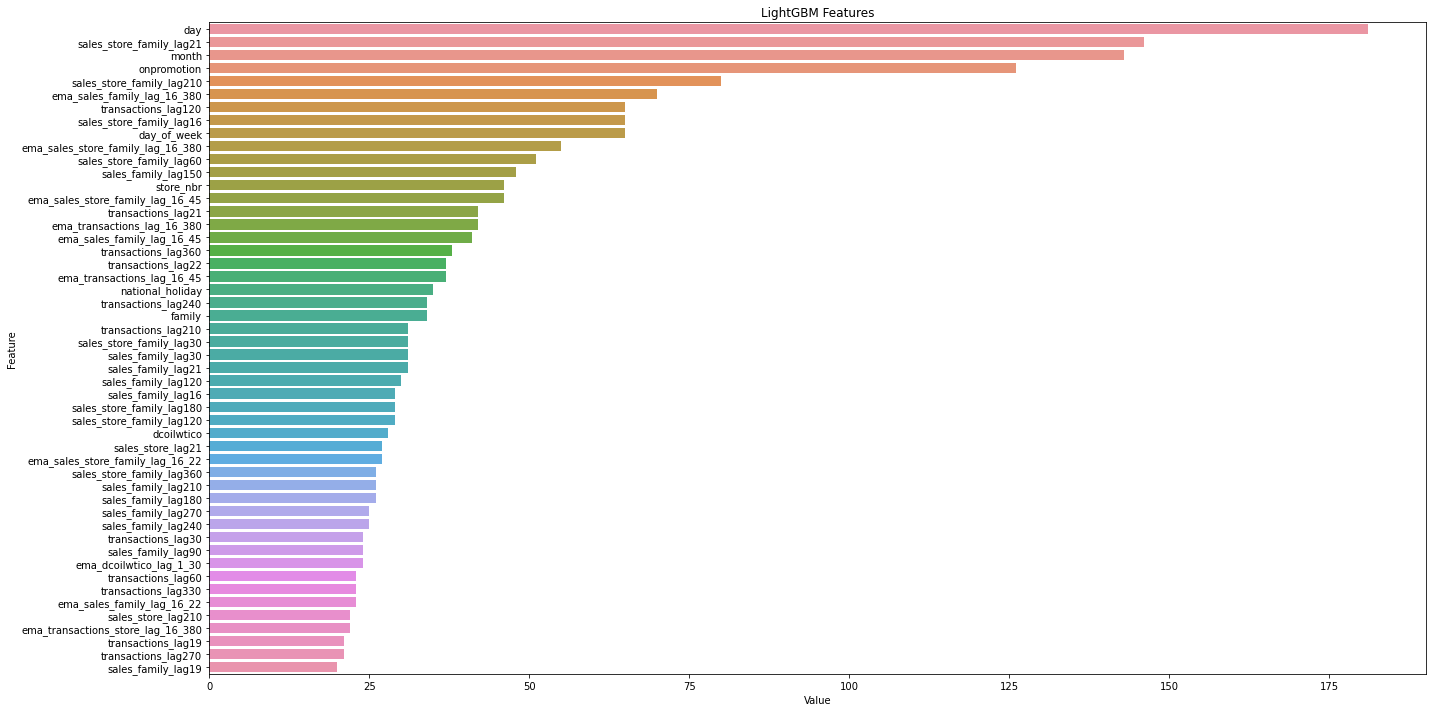

In [9]:
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.head(50))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()

In [10]:
sorted_features = feature_imp.Feature.tolist()

dict_results = {'Features': [],
                'Mean RMSLE CV': [],
                'Execution Time (s)':  []}

for i in tqdm(list(reversed((range(0, 100))))):
    
    rmsle_folds = []
    time_folds = []
    tscv = TimeSeriesSplit(n_splits=5, test_size=15)
    for fold, (train_index, test_index) in (enumerate(tscv.split(dates))):
        ini = time.time()

        dates_train, dates_test = dates[train_index], dates[test_index]
        df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
        X_train, X_test = df_train[sorted_features[:i+1]], df_test[sorted_features[:i+1]]
        y_train, y_test = df_train[target], df_test[target]

        numeric_features = X_train[sorted_features[:i+1]].select_dtypes(include=['int', 'float']).columns.tolist()
        categorical_features = [ft for ft in sorted_features[:i+1] if ft not in numeric_features]

        for c in categorical_features:
            encoder = LabelEncoder()
            X_train[c] = encoder.fit_transform(X_train[c])
            X_test[c] = encoder.transform(X_test[c])

        model = LGBMRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        preds = [a if a>0 else 0 for a in preds]

        rmsle = mean_squared_log_error(y_test, preds, squared=False)
        fim = time.time()

        exec_time = fim-ini

        rmsle_folds.append(rmsle)
        time_folds.append(exec_time)
        
        del df_train, df_test, X_train, X_test, y_train, y_test

    rmsle = np.mean(rmsle_folds)
    time_exec = np.mean(time_folds)
    
    dict_results['Features'].append(sorted_features[:i+1])
    dict_results['Mean RMSLE CV'].append(rmsle)
    dict_results['Execution Time (s)'].append(time_exec)
    

100%|██████████| 100/100 [2:57:22<00:00, 106.42s/it] 


In [11]:
df_results = pd.DataFrame(dict_results)
df_results

,Features,Mean RMSLE CV,Execution Time (s)
0,"[day, sales_store_family_lag21, month, onpromo...",0.791606,34.519236
1,"[day, sales_store_family_lag21, month, onpromo...",0.809001,31.422360
2,"[day, sales_store_family_lag21, month, onpromo...",0.792588,33.303733
3,"[day, sales_store_family_lag21, month, onpromo...",0.792307,32.060464
4,"[day, sales_store_family_lag21, month, onpromo...",0.805116,35.478987
...,...,...,...
95,"[day, sales_store_family_lag21, month, onpromo...",1.026068,5.625626
96,"[day, sales_store_family_lag21, month, onpromo...",1.199647,5.476499
97,"[day, sales_store_family_lag21, month]",1.360363,5.077819
98,"[day, sales_store_family_lag21]",1.276195,5.250090


In [23]:
# df_results.to_csv('data_results/LGBM_Feature_Selection_CV.csv', index=False)
df_results = pd.read_csv('data_results/LGBM_Feature_Selection_CV.csv')
df_results['Features'] = df_results['Features'].apply(lambda x: x[1:-1].replace("'", "").replace(" ", "").split(','))
df_results

,Features,Mean RMSLE CV,Execution Time (s)
0,"[day, sales_store_family_lag21, month, onpromo...",0.791606,34.519236
1,"[day, sales_store_family_lag21, month, onpromo...",0.809001,31.422360
2,"[day, sales_store_family_lag21, month, onpromo...",0.792588,33.303733
3,"[day, sales_store_family_lag21, month, onpromo...",0.792307,32.060464
4,"[day, sales_store_family_lag21, month, onpromo...",0.805116,35.478987
...,...,...,...
95,"[day, sales_store_family_lag21, month, onpromo...",1.026068,5.625626
96,"[day, sales_store_family_lag21, month, onpromo...",1.199647,5.476499
97,"[day, sales_store_family_lag21, month]",1.360363,5.077819
98,"[day, sales_store_family_lag21]",1.276195,5.250090


In [24]:
df_results.Features.tolist()[-1]

['day']

In [25]:
df_results['Len_Features'] = df_results['Features'].apply(lambda x: len(x))

In [26]:
df_results = df_results.sort_values('Len_Features')
df_results.head(30)

,Features,Mean RMSLE CV,Execution Time (s),Len_Features
99,[day],3.464874,5.536390,1
98,"[day, sales_store_family_lag21]",1.276195,5.250090,2
97,"[day, sales_store_family_lag21, month]",1.360363,5.077819,3
96,"[day, sales_store_family_lag21, month, onpromo...",1.199647,5.476499,4
95,"[day, sales_store_family_lag21, month, onpromo...",1.026068,5.625626,5
94,"[day, sales_store_family_lag21, month, onpromo...",0.800302,6.017958,6
93,"[day, sales_store_family_lag21, month, onpromo...",0.763874,6.653441,7
92,"[day, sales_store_family_lag21, month, onpromo...",0.781150,6.487869,8
91,"[day, sales_store_family_lag21, month, onpromo...",0.775742,6.988663,9
90,"[day, sales_store_family_lag21, month, onpromo...",0.781749,7.077693,10


Text(0, 0.5, 'RMSLE')

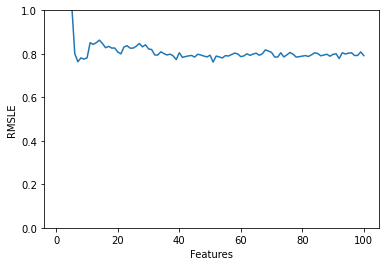

In [27]:
plt.plot(df_results.Len_Features, df_results['Mean RMSLE CV'])
plt.ylim(0, 1)
plt.xlabel('Features')
plt.ylabel('RMSLE')

In [28]:
df_results.sort_values('Mean RMSLE CV')

,Features,Mean RMSLE CV,Execution Time (s),Len_Features
49,"[day, sales_store_family_lag21, month, onpromo...",0.762259,21.889505,51
93,"[day, sales_store_family_lag21, month, onpromo...",0.763874,6.653441,7
61,"[day, sales_store_family_lag21, month, onpromo...",0.773357,18.605233,39
91,"[day, sales_store_family_lag21, month, onpromo...",0.775742,6.988663,9
8,"[day, sales_store_family_lag21, month, onpromo...",0.778467,33.199646,92
...,...,...,...,...
95,"[day, sales_store_family_lag21, month, onpromo...",1.026068,5.625626,5
96,"[day, sales_store_family_lag21, month, onpromo...",1.199647,5.476499,4
98,"[day, sales_store_family_lag21]",1.276195,5.250090,2
97,"[day, sales_store_family_lag21, month]",1.360363,5.077819,3


In [29]:
display(df_results[df_results['Len_Features'].between(46, 56)])
display(df_results[df_results['Len_Features'].between(34, 44)])

,Features,Mean RMSLE CV,Execution Time (s),Len_Features
54,"[day, sales_store_family_lag21, month, onpromo...",0.798329,20.070632,46
53,"[day, sales_store_family_lag21, month, onpromo...",0.794549,19.511295,47
52,"[day, sales_store_family_lag21, month, onpromo...",0.789922,23.688288,48
51,"[day, sales_store_family_lag21, month, onpromo...",0.785901,22.163886,49
50,"[day, sales_store_family_lag21, month, onpromo...",0.793740,21.923632,50
49,"[day, sales_store_family_lag21, month, onpromo...",0.762259,21.889505,51
48,"[day, sales_store_family_lag21, month, onpromo...",0.790020,23.667422,52
47,"[day, sales_store_family_lag21, month, onpromo...",0.785809,21.507999,53
46,"[day, sales_store_family_lag21, month, onpromo...",0.781109,22.679491,54
45,"[day, sales_store_family_lag21, month, onpromo...",0.791776,23.140676,55


,Features,Mean RMSLE CV,Execution Time (s),Len_Features
66,"[day, sales_store_family_lag21, month, onpromo...",0.809486,15.396354,34
65,"[day, sales_store_family_lag21, month, onpromo...",0.801037,16.432626,35
64,"[day, sales_store_family_lag21, month, onpromo...",0.794849,16.146022,36
63,"[day, sales_store_family_lag21, month, onpromo...",0.798707,17.957856,37
62,"[day, sales_store_family_lag21, month, onpromo...",0.790688,15.944548,38
61,"[day, sales_store_family_lag21, month, onpromo...",0.773357,18.605233,39
60,"[day, sales_store_family_lag21, month, onpromo...",0.805168,18.193529,40
59,"[day, sales_store_family_lag21, month, onpromo...",0.783866,16.936870,41
58,"[day, sales_store_family_lag21, month, onpromo...",0.787542,19.641757,42
57,"[day, sales_store_family_lag21, month, onpromo...",0.790598,18.724325,43


### Experimento 3.1 - 24 folds, 15 days each fold, 51 features

In [30]:
features_51 = df_results[df_results['Len_Features'] == 51]['Features'].tolist()[0]
features_51

['day',
 'sales_store_family_lag21',
 'month',
 'onpromotion',
 'sales_store_family_lag210',
 'ema_sales_family_lag_16_380',
 'transactions_lag120',
 'sales_store_family_lag16',
 'day_of_week',
 'ema_sales_store_family_lag_16_380',
 'sales_store_family_lag60',
 'sales_family_lag150',
 'store_nbr',
 'ema_sales_store_family_lag_16_45',
 'transactions_lag21',
 'ema_transactions_lag_16_380',
 'ema_sales_family_lag_16_45',
 'transactions_lag360',
 'transactions_lag22',
 'ema_transactions_lag_16_45',
 'national_holiday',
 'transactions_lag240',
 'family',
 'transactions_lag210',
 'sales_store_family_lag30',
 'sales_family_lag30',
 'sales_family_lag21',
 'sales_family_lag120',
 'sales_family_lag16',
 'sales_store_family_lag180',
 'sales_store_family_lag120',
 'dcoilwtico',
 'sales_store_lag21',
 'ema_sales_store_family_lag_16_22',
 'sales_store_family_lag360',
 'sales_family_lag210',
 'sales_family_lag180',
 'sales_family_lag270',
 'sales_family_lag240',
 'transactions_lag30',
 'sales_family_

In [29]:
dates = df.date.unique()

rmsle_folds = []
time_folds = []
tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    X_train, X_test = df_train[features_51], df_test[features_51]
    y_train, y_test = df_train[target], df_test[target]
    
    numeric_features = X_train[features_51].select_dtypes(include=['int', 'float']).columns.tolist()
    categorical_features = [ft for ft in features_51 if ft not in numeric_features]

    for c in categorical_features:
        encoder = LabelEncoder()
        X_train[c] = encoder.fit_transform(X_train[c])
        X_test[c] = encoder.transform(X_test[c])

    model = LGBMRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    rmsle_folds.append(rmsle)
    time_folds.append(exec_time)
    
print("Mean RMSLE CV:", np.mean(rmsle_folds))
print("Mean Execution Time:", np.mean(time_folds))

24it [07:15, 18.14s/it]

Mean RMSLE CV: 0.9305952140088913
Mean Execution Time: 18.13782529036204


### Experimento 3.2 24 folds, 15 days each fold, 39 features

In [30]:
features_39 = df_results[df_results['Len_Features'] == 39]['Features'].tolist()[0]
features_39

['day',
 'sales_store_family_lag21',
 'month',
 'onpromotion',
 'sales_store_family_lag210',
 'ema_sales_family_lag_16_380',
 'transactions_lag120',
 'sales_store_family_lag16',
 'day_of_week',
 'ema_sales_store_family_lag_16_380',
 'sales_store_family_lag60',
 'sales_family_lag150',
 'store_nbr',
 'ema_sales_store_family_lag_16_45',
 'transactions_lag21',
 'ema_transactions_lag_16_380',
 'ema_sales_family_lag_16_45',
 'transactions_lag360',
 'transactions_lag22',
 'ema_transactions_lag_16_45',
 'national_holiday',
 'transactions_lag240',
 'family',
 'transactions_lag210',
 'sales_store_family_lag30',
 'sales_family_lag30',
 'sales_family_lag21',
 'sales_family_lag120',
 'sales_family_lag16',
 'sales_store_family_lag180',
 'sales_store_family_lag120',
 'dcoilwtico',
 'sales_store_lag21',
 'ema_sales_store_family_lag_16_22',
 'sales_store_family_lag360',
 'sales_family_lag210',
 'sales_family_lag180',
 'sales_family_lag270',
 'sales_family_lag240']

In [31]:
dates = df.date.unique()

rmsle_folds = []
time_folds = []
tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    X_train, X_test = df_train[features_39], df_test[features_39]
    y_train, y_test = df_train[target], df_test[target]
    
    numeric_features = X_train[features_39].select_dtypes(include=['int', 'float']).columns.tolist()
    categorical_features = [ft for ft in features_39 if ft not in numeric_features]

    for c in categorical_features:
        encoder = LabelEncoder()
        X_train[c] = encoder.fit_transform(X_train[c])
        X_test[c] = encoder.transform(X_test[c])

    model = LGBMRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    rmsle_folds.append(rmsle)
    time_folds.append(exec_time)
    
print("Mean RMSLE CV:", np.mean(rmsle_folds))
print("Mean Execution Time:", np.mean(time_folds))

24it [06:09, 15.40s/it]

Mean RMSLE CV: 0.9384804992220461
Mean Execution Time: 15.402090718348822


### Experimento 3.3 24 folds, 15 days each fold, 9 features

In [32]:
features_9 = df_results[df_results['Len_Features'] == 9]['Features'].tolist()[0]
features_9

['day',
 'sales_store_family_lag21',
 'month',
 'onpromotion',
 'sales_store_family_lag210',
 'ema_sales_family_lag_16_380',
 'transactions_lag120',
 'sales_store_family_lag16',
 'day_of_week']

In [35]:
dates = df.date.unique()

rmsle_folds = []
time_folds = []
tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    X_train, X_test = df_train[features_9], df_test[features_9]
    y_train, y_test = df_train[target], df_test[target]
    
    numeric_features = X_train[features_9].select_dtypes(include=['int', 'float']).columns.tolist()
    categorical_features = [ft for ft in features_9 if ft not in numeric_features]

    for c in categorical_features:
        encoder = LabelEncoder()
        X_train[c] = encoder.fit_transform(X_train[c])
        X_test[c] = encoder.transform(X_test[c])

    model = LGBMRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    rmsle_folds.append(rmsle)
    time_folds.append(exec_time)
    
print("Mean RMSLE CV:", np.mean(rmsle_folds))
print("Mean Execution Time:", np.mean(time_folds))

24it [02:30,  6.28s/it]

Mean RMSLE CV: 0.9456401332632819
Mean Execution Time: 6.283421436945598


### Experimento 3.4 24 folds, 15 days each fold, 7 features

In [36]:
features_7 = df_results[df_results['Len_Features'] == 7]['Features'].tolist()[0]
features_7

['day',
 'sales_store_family_lag21',
 'month',
 'onpromotion',
 'sales_store_family_lag210',
 'ema_sales_family_lag_16_380',
 'transactions_lag120']

In [37]:
dates = df.date.unique()

rmsle_folds = []
time_folds = []
tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    X_train, X_test = df_train[features_7], df_test[features_7]
    y_train, y_test = df_train[target], df_test[target]
    
    numeric_features = X_train[features_7].select_dtypes(include=['int', 'float']).columns.tolist()
    categorical_features = [ft for ft in features_7 if ft not in numeric_features]

    for c in categorical_features:
        encoder = LabelEncoder()
        X_train[c] = encoder.fit_transform(X_train[c])
        X_test[c] = encoder.transform(X_test[c])

    model = LGBMRegressor()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    rmsle_folds.append(rmsle)
    time_folds.append(exec_time)
    
print("Mean RMSLE CV:", np.mean(rmsle_folds))
print("Mean Execution Time:", np.mean(time_folds))

24it [02:22,  5.95s/it]

Mean RMSLE CV: 0.9489903372251751
Mean Execution Time: 5.9536169568697614


# Experimento 4: Preprocessing Techniques

In [7]:
features_51 = ['day',
 'sales_store_family_lag21',
 'month',
 'onpromotion',
 'sales_store_family_lag210',
 'ema_sales_family_lag_16_380',
 'transactions_lag120',
 'sales_store_family_lag16',
 'day_of_week',
 'ema_sales_store_family_lag_16_380',
 'sales_store_family_lag60',
 'sales_family_lag150',
 'store_nbr',
 'ema_sales_store_family_lag_16_45',
 'transactions_lag21',
 'ema_transactions_lag_16_380',
 'ema_sales_family_lag_16_45',
 'transactions_lag360',
 'transactions_lag22',
 'ema_transactions_lag_16_45',
 'national_holiday',
 'transactions_lag240',
 'family',
 'transactions_lag210',
 'sales_store_family_lag30',
 'sales_family_lag30',
 'sales_family_lag21',
 'sales_family_lag120',
 'sales_family_lag16',
 'sales_store_family_lag180',
 'sales_store_family_lag120',
 'dcoilwtico',
 'sales_store_lag21',
 'ema_sales_store_family_lag_16_22',
 'sales_store_family_lag360',
 'sales_family_lag210',
 'sales_family_lag180',
 'sales_family_lag270',
 'sales_family_lag240',
 'transactions_lag30',
 'sales_family_lag90',
 'ema_dcoilwtico_lag_1_30',
 'transactions_lag60',
 'transactions_lag330',
 'ema_sales_family_lag_16_22',
 'sales_store_lag210',
 'ema_transactions_store_lag_16_380',
 'transactions_lag19',
 'transactions_lag270',
 'sales_family_lag19',
 'transactions_lag18']

## Encoders

In [8]:
numeric_features = df[features_51].select_dtypes(include=['int', 'float']).columns.tolist()
categorical_features = [ft for ft in features_51 if ft not in numeric_features]
categorical_features

['family']

In [9]:
dict_encoders = {'CatBoost': ce.CatBoostEncoder(cols=categorical_features),
                 'Count': ce.CountEncoder(cols=categorical_features),
                 'JamesStein': ce.JamesSteinEncoder(cols=categorical_features),
                 'MEStimate': ce.MEstimateEncoder(cols=categorical_features),
                 'OneHot': ce.OneHotEncoder(cols=categorical_features),
                 'Ordinal': ce.OrdinalEncoder(cols=categorical_features),
                 'Polynomial': ce.PolynomialEncoder(cols=categorical_features),
                 'Sum': ce.SumEncoder(cols=categorical_features),
                 'Target': ce.TargetEncoder(cols=categorical_features),
                 'Quantile': ce.QuantileEncoder(cols=categorical_features)}

In [10]:
dates = df.date.unique()

dict_results = {'Fold': [],
                'Encoder': [],
                'RMSLE': [],
                'Time': []}

tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for fold, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    for name_encoder, encoder in (dict_encoders.items()):
    
        ini = time.time()

        dates_train, dates_test = dates[train_index], dates[test_index]
        df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
        X_train, X_test = df_train[features_51], df_test[features_51]
        y_train, y_test = df_train[target], df_test[target]

        pipeline = Pipeline([('encoder', encoder),
                             ('model', LGBMRegressor())])

        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)
        preds = [a if a>0 else 0 for a in preds]

        rmsle = mean_squared_log_error(y_test, preds, squared=False)
        fim = time.time()

        exec_time = fim-ini
        
        dict_results['Fold'].append(fold)
        dict_results['Encoder'].append(name_encoder)
        dict_results['RMSLE'].append(rmsle)
        dict_results['Time'].append(exec_time)

24it [1:34:30, 236.28s/it]


In [11]:
df_results = pd.DataFrame(dict_results)

In [12]:
df_results.to_csv('data_results/LGBM_Encoders_CV.csv', index=False)
df_results = pd.read_csv('data_results/LGBM_Encoders_CV.csv')
df_results

,Fold,Encoder,RMSLE,Time
0,0,CatBoost,1.141754,15.595771
1,0,Count,1.157171,17.128348
2,0,JamesStein,1.112371,18.254802
3,0,MEStimate,1.150838,18.181785
4,0,OneHot,1.183982,22.586155
...,...,...,...,...
235,23,Ordinal,0.787538,23.333330
236,23,Polynomial,0.825329,39.826492
237,23,Sum,0.868427,31.712146
238,23,Target,0.779744,26.330239


In [13]:
df_results.groupby('Encoder').RMSLE.agg(['mean', 'std'])

,mean,std
Encoder,,
CatBoost,0.944666,0.212674
Count,0.933160,0.196612
JamesStein,0.944276,0.206360
MEStimate,0.945725,0.203979
OneHot,0.948140,0.202467
Ordinal,0.930595,0.209040
Polynomial,0.945767,0.192642
Quantile,0.938701,0.197406
Sum,0.948140,0.202467


## store_nbr as categorical

In [9]:
dates = df.date.unique()

rmsle_folds = []
time_folds = []
tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    
    df_train['store_nbr'] = df_train['store_nbr'].astype(str)
    df_test['store_nbr'] = df_test['store_nbr'].astype(str)
    
    X_train, X_test = df_train[features_51], df_test[features_51]
    y_train, y_test = df_train[target], df_test[target]
    
    numeric_features = X_train[features_51].select_dtypes(include=['int', 'float']).columns.tolist()
    categorical_features = [ft for ft in features_51 if ft not in numeric_features]

    pipeline = Pipeline([('encoder', ce.OrdinalEncoder(cols=categorical_features)),
                         ('model', LGBMRegressor())])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    rmsle_folds.append(rmsle)
    time_folds.append(exec_time)
    
print("Mean RMSLE CV:", np.mean(rmsle_folds))
print("Mean Execution Time:", np.mean(time_folds))

24it [08:17, 20.71s/it]

Mean RMSLE CV: 0.9305952140088897
Mean Execution Time: 20.711034893989563


## Scaling Tests

In [12]:
dict_scalers = {'Standard': preprocessing.StandardScaler(),
                'MinMax': preprocessing.MinMaxScaler(),
                'MaxAbs': preprocessing.MaxAbsScaler(),
                'Normalizer': preprocessing.Normalizer()}

In [14]:
dates = df.date.unique()

dict_results = {'Fold': [],
                'Scaler': [],
                'RMSLE': [],
                'Time': []}

tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for fold, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    for name_scaler, scaler in (dict_scalers.items()):
    
        ini = time.time()

        dates_train, dates_test = dates[train_index], dates[test_index]
        df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
        X_train, X_test = df_train[features_51], df_test[features_51]
        y_train, y_test = df_train[target], df_test[target]
        
        numeric_features = X_train[features_51].select_dtypes(include=['int', 'float']).columns.tolist()
        categorical_features = [ft for ft in features_51 if ft not in numeric_features]
        
        pipeline = Pipeline([('encoder', ce.OrdinalEncoder(cols=categorical_features)),
                             ('scaler', scaler), 
                             ('model', LGBMRegressor())])

        pipeline.fit(X_train, y_train)
        preds = pipeline.predict(X_test)
        preds = [a if a>0 else 0 for a in preds]

        rmsle = mean_squared_log_error(y_test, preds, squared=False)
        fim = time.time()

        exec_time = fim-ini
        
        dict_results['Fold'].append(fold)
        dict_results['Scaler'].append(name_scaler)
        dict_results['RMSLE'].append(rmsle)
        dict_results['Time'].append(exec_time)

24it [32:22, 80.94s/it]


In [15]:
df_results = pd.DataFrame(dict_results)

In [16]:
df_results.to_csv('data_results/LGBM_Scalers_CV.csv', index=False)
df_results = pd.read_csv('data_results/LGBM_Scalers_CV.csv')
df_results

,Fold,Scaler,RMSLE,Time
0,0,Standard,1.200812,18.393287
1,0,MinMax,1.151491,16.720810
2,0,MaxAbs,1.125957,16.972136
3,0,Normalizer,1.158575,16.662611
4,1,Standard,1.209627,17.517350
...,...,...,...,...
91,22,Normalizer,0.779054,22.657779
92,23,Standard,0.859281,23.550122
93,23,MinMax,0.810540,23.405436
94,23,MaxAbs,0.824649,22.902039


In [18]:
df_results.groupby('Scaler').RMSLE.agg(['mean', 'std'])

,mean,std
Scaler,,
MaxAbs,0.933355,0.193954
MinMax,0.937152,0.207942
Normalizer,0.958951,0.215386
Standard,0.950044,0.212749


## Hyperparameter Optimization

In [8]:
gridParams = {
    'model__learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
    'model__n_estimators': [10, 50, 100, 500],
    'model__num_leaves': [50, 100,200],
    'model__max_depth' : [3,4,5,6,7,8],
    'model__random_state' : [42], 
    'model__colsample_bytree' : [0.5,0.7],
    'model__subsample' : [0.5, 0.7, 1.0],
    'model__min_split_gain' : [0.01],
    'model__min_data_in_leaf':[10, 100, 1000]
}

X = df[features_51]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, shuffle=False)
tscv = TimeSeriesSplit(n_splits=5, test_size=15*54*33)

pipeline = Pipeline([('encoder', ce.OrdinalEncoder(cols=categorical_features)),
                     ('model', LGBMRegressor())])
random_search = RandomizedSearchCV(pipeline,gridParams,scoring='neg_mean_squared_log_error',verbose=2)
search_results = random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=7, model__min_data_in_leaf=10, model__min_split_gain=0.01, model__n_estimators=50, model__num_leaves=200, model__random_state=42, model__subsample=1.0; total time=   0.4s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=7, model__min_data_in_leaf=10, model__min_split_gain=0.01, model__n_estimators=50, model__num_leaves=200, model__random_state=42, model__subsample=1.0; total time=   0.3s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=7, model__min_data_in_leaf=10, model__min_split_gain=0.01, model__n_estimators=50, model__num_leaves=200, model__random_state=42, model__subsample=1.0; total time=   0.3s
[CV] END model__colsample_bytree=0.7, model__learning_rate=0.01, model__max_depth=7, model__min_data_in_leaf=10, model__min_split_gain=0.01, model__n_estimators=50, model__num_leav


KeyboardInterrupt



In [ ]:
search_results.best_params_

In [9]:
params = {'subsample': 1.0, 
          'random_state': 42, 
          'num_leaves': 100, 
          'n_estimators': 10,
          'min_split_gain': 0.01,
          'min_data_in_leaf': 100,
          'max_depth': 7,
          'learning_rate': 0.1,
          'colsample_bytree': 0.7}

dates = df.date.unique()

rmsle_folds = []
time_folds = []
tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    
    X_train, X_test = df_train[features_51], df_test[features_51]
    y_train, y_test = df_train[target], df_test[target]
    
    numeric_features = X_train[features_51].select_dtypes(include=['int', 'float']).columns.tolist()
    categorical_features = [ft for ft in features_51 if ft not in numeric_features]

    pipeline = Pipeline([('encoder', ce.OrdinalEncoder(cols=categorical_features)),
                         ('model', LGBMRegressor(**params))])

    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    rmsle_folds.append(rmsle)
    time_folds.append(exec_time)
    
print("Mean RMSLE CV:", np.mean(rmsle_folds))
print("Mean Execution Time:", np.mean(time_folds))

0it [00:00, ?it/s]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


1it [00:08,  8.83s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


2it [00:16,  8.23s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


3it [00:24,  8.26s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


4it [00:34,  8.60s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


5it [00:44,  9.12s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


6it [00:54,  9.50s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


7it [01:03,  9.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


8it [01:12,  9.29s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


9it [01:22,  9.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


10it [01:33,  9.79s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


11it [01:44, 10.17s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


12it [01:55, 10.48s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


13it [02:05, 10.43s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


14it [02:15, 10.36s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


15it [02:26, 10.35s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


16it [02:36, 10.46s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


17it [02:47, 10.42s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


18it [02:59, 10.87s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


19it [03:12, 11.49s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


20it [03:23, 11.57s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


21it [03:35, 11.56s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


22it [03:46, 11.55s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


23it [03:58, 11.63s/it]

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100


24it [04:10, 10.43s/it]

Mean RMSLE CV: 2.7415745689291637
Mean Execution Time: 10.431004812320074


# Final Model

## 24 folds, 15 days each fold

In [7]:
features_51 = ['day',
 'sales_store_family_lag21',
 'month',
 'onpromotion',
 'sales_store_family_lag210',
 'ema_sales_family_lag_16_380',
 'transactions_lag120',
 'sales_store_family_lag16',
 'day_of_week',
 'ema_sales_store_family_lag_16_380',
 'sales_store_family_lag60',
 'sales_family_lag150',
 'store_nbr',
 'ema_sales_store_family_lag_16_45',
 'transactions_lag21',
 'ema_transactions_lag_16_380',
 'ema_sales_family_lag_16_45',
 'transactions_lag360',
 'transactions_lag22',
 'ema_transactions_lag_16_45',
 'national_holiday',
 'transactions_lag240',
 'family',
 'transactions_lag210',
 'sales_store_family_lag30',
 'sales_family_lag30',
 'sales_family_lag21',
 'sales_family_lag120',
 'sales_family_lag16',
 'sales_store_family_lag180',
 'sales_store_family_lag120',
 'dcoilwtico',
 'sales_store_lag21',
 'ema_sales_store_family_lag_16_22',
 'sales_store_family_lag360',
 'sales_family_lag210',
 'sales_family_lag180',
 'sales_family_lag270',
 'sales_family_lag240',
 'transactions_lag30',
 'sales_family_lag90',
 'ema_dcoilwtico_lag_1_30',
 'transactions_lag60',
 'transactions_lag330',
 'ema_sales_family_lag_16_22',
 'sales_store_lag210',
 'ema_transactions_store_lag_16_380',
 'transactions_lag19',
 'transactions_lag270',
 'sales_family_lag19',
 'transactions_lag18']

In [9]:
dates = df.date.unique()

dict_results_CV = {'Fold': [],
                   'Start Test': [],
                   'End Test': [],
                   'RMSLE': [],
                   'Execution Time': []}

tscv = TimeSeriesSplit(n_splits=24, test_size=15)
for i, (train_index, test_index) in tqdm(enumerate(tscv.split(dates))):
    ini = time.time()
    
    dates_train, dates_test = dates[train_index], dates[test_index]
    df_train, df_test = df[df['date'].isin(dates_train)], df[df['date'].isin(dates_test)]
    X_train, X_test = df_train[features_51], df_test[features_51]
    y_train, y_test = df_train[target], df_test[target]
    
    numeric_features = X_train[features_51].select_dtypes(include=['int', 'float']).columns.tolist()
    categorical_features = [ft for ft in features_51 if ft not in numeric_features]
    
    pipeline = Pipeline([('encoder', ce.OrdinalEncoder(cols=categorical_features)),
                         ('model', LGBMRegressor())])
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    preds = [a if a>0 else 0 for a in preds]

    rmsle = mean_squared_log_error(y_test, preds, squared=False)
    fim = time.time()
    
    exec_time = fim-ini
    
    dict_results_CV['Fold'].append(i)
    dict_results_CV['Start Test'].append(df_test.date.min())
    dict_results_CV['End Test'].append(df_test.date.max())
    dict_results_CV['RMSLE'].append(rmsle)
    dict_results_CV['Execution Time'].append(exec_time)

24it [07:53, 19.75s/it]


In [10]:
df_results_CV = pd.DataFrame(dict_results_CV)
display(df_results_CV)

,Fold,Start Test,End Test,RMSLE,Execution Time
0,0,2016-08-21,2016-09-04,1.148184,16.434967
1,1,2016-09-05,2016-09-19,1.161792,16.847459
2,2,2016-09-20,2016-10-04,1.070279,16.468185
3,3,2016-10-05,2016-10-19,1.147687,17.567670
4,4,2016-10-20,2016-11-03,0.999611,17.974633
5,5,2016-11-04,2016-11-18,1.034793,18.354170
6,6,2016-11-19,2016-12-03,0.985595,19.464082
7,7,2016-12-04,2016-12-18,1.110171,18.479496
8,8,2016-12-19,2017-01-02,1.636673,18.356689
9,9,2017-01-03,2017-01-17,0.909941,19.048785


In [11]:
df_results_CV.describe()

,Fold,RMSLE,Execution Time
count,24.000000,24.000000,24.000000
mean,11.500000,0.930595,19.745446
std,7.071068,0.209040,2.035547
min,0.000000,0.698677,16.434967
25%,5.750000,0.794668,18.356059
50%,11.500000,0.848577,19.827713
75%,17.250000,1.043664,20.853859
max,23.000000,1.636673,23.779286


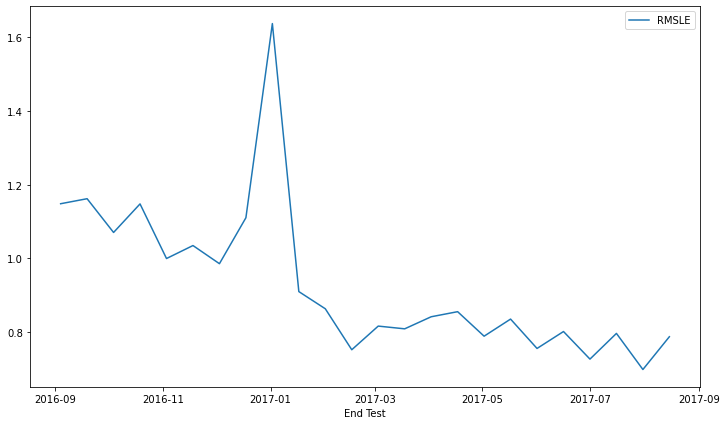

In [12]:
fig, (ax1) = plt.subplots(1,1,figsize=(12, 7))
sns.lineplot(data=df_results_CV[['End Test', 'RMSLE']].set_index('End Test'), ax=ax1)
plt.show()

Considerações sobre os testes:
- O modelo ficou bem pior do que os SARIMAs (RMSLE de 0.930595 versus 0.580451).
- Um possível motivo para isso é o uso de variáveis a partir do lag 16. Como o SARIMA usa as predições anteriores o novo lag1 em forecasts maiores do que 1 período, provavelmente esse ajuste foi melhor do que usar informações 15 dias defasadas como no modelo de boosting.
- Uma alternativa para isso seria ajustar um modelo de boosting para cada período de predição a frente (Ex: 1 modelo para 1 dia a frente, 1 modelo para 2 dias a frente, ..., 1 modelo para 15 dias a frente). Dessa maneira, apenas o modelo de 15 dias a frente usaria variáveis do lag16 para trás.
- Poucas das técnicas testadas de fato melhoraram a performance. Apenas a seleção de features conseguiu reduzir o RMSLE ao passo que reduziu complexidade do modelo (menor tempo de treinamento).
- Ao plotar o RMSLE ao longo do tempo nos folds de validação, existe uma tendência de queda. Isso é um bom indicativo de que conforme mais dados vão sendo coletados e o modelo vai sendo reajustado, as predições podem ficar cada vez melhores.